In [2]:
import numpy as np
from sklearn.decomposition import DictionaryLearning
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.preprocessing import StandardScaler




In [3]:
# Load the saved image
image_path = "beagle_image.png"
loaded_image = Image.open(image_path)


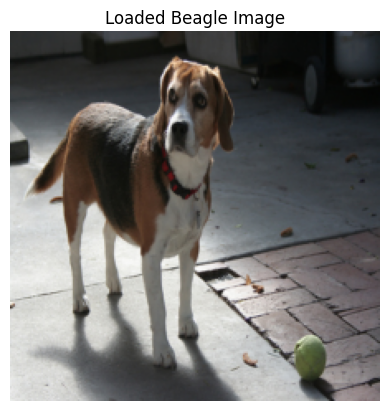

In [4]:
# Display the loaded image
plt.imshow(loaded_image)
plt.axis("off")
plt.title("Loaded Beagle Image")
plt.show()


Put the images into patches, display them, and store them in a dictionary

In [5]:
def extract_patches_with_unfold(image_tensor, patch_size=32, stride=16):
    """Extract patches using torch.nn.Unfold."""
    _, height, width = image_tensor.shape  # Assume shape (C, H, W)
    unfolded = torch.nn.functional.unfold(
        image_tensor.unsqueeze(0),  # Add batch dimension
        kernel_size=(patch_size, patch_size),
        stride=(stride, stride)
    )
    patches = unfolded.permute(0, 2, 1)  # Rearrange dimensions for easy access
    patches = patches.squeeze(0)  # Remove batch dimension
    patches = patches.reshape(-1, 3, patch_size, patch_size)  # Reshape to (N, C, patch_size, patch_size)
    return patches


In [6]:
# Define the transformation to convert a PIL image to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to a PyTorch tensor (C, H, W)
])

# Example usage with a PIL image
patch_size = 32
stride = 20

# Convert the loaded image (PIL) to a tensor
image_tensor = transform(loaded_image)

# Extract patches
patches_tensor = extract_patches_with_unfold(image_tensor, patch_size=patch_size, stride=stride)
print("Total patches created:", patches_tensor.size(0))

Total patches created: 100


In [ ]:
Display the patches 

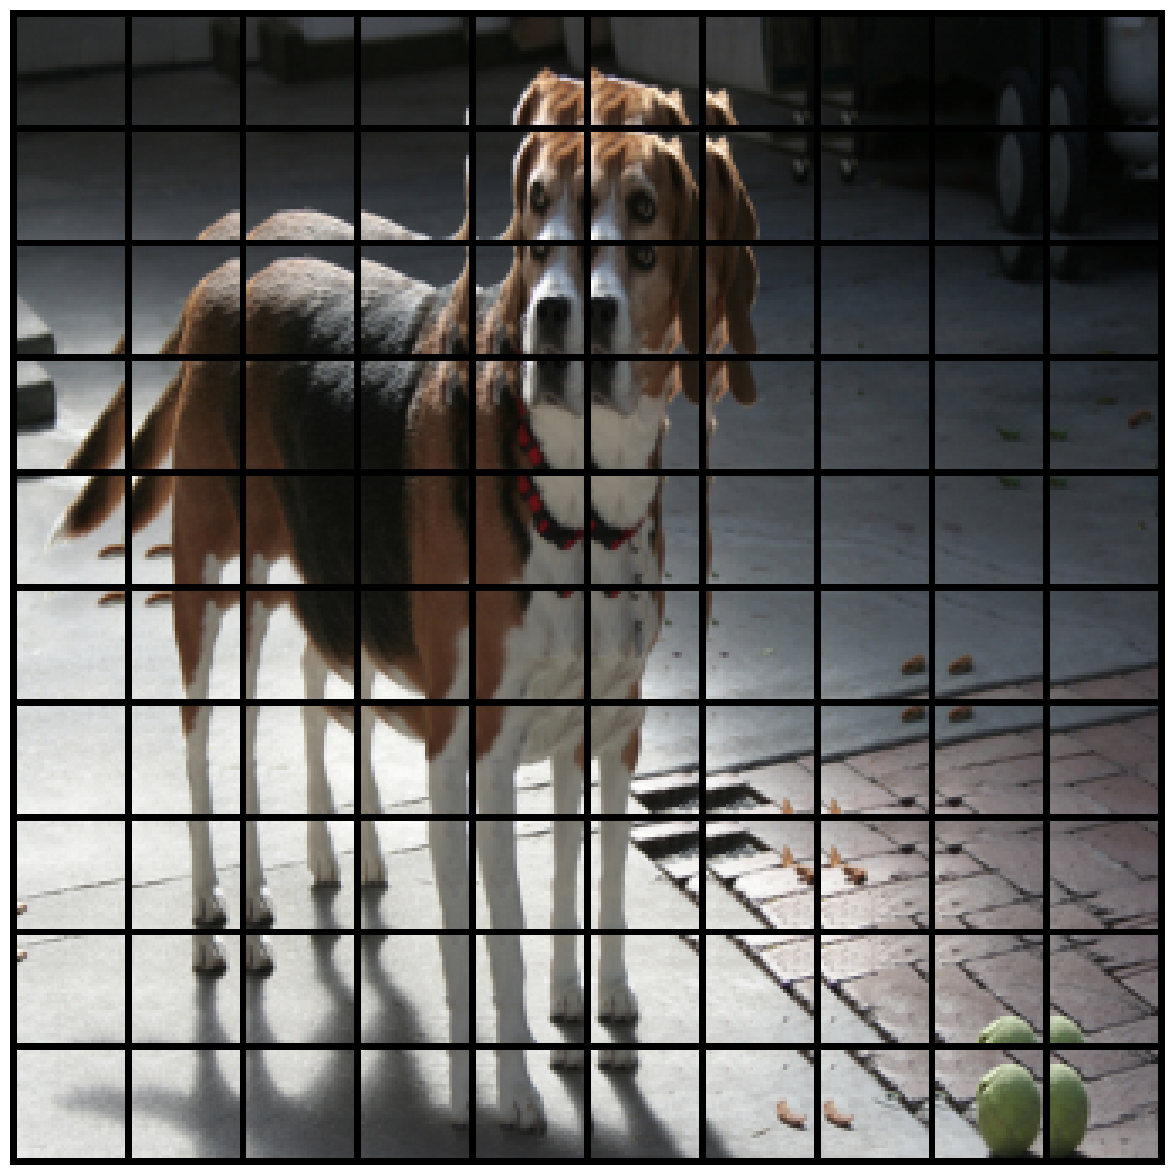

In [9]:
def display_patches(patches, cols=10):
    """Display extracted patches in a grid."""
    #num_patches = patches.size(0)  # Total number of patches
    num_patches = len(patches)
    rows = (num_patches + cols - 1) // cols  # Calculate required rows for the grid
    
    # Create a grid of patches using torchvision.utils.make_grid
    patches_grid = make_grid(patches, nrow=cols, normalize=True, padding=2)  # Normalize for better visualization
    
    # Convert grid to numpy and display
    plt.figure(figsize=(15, rows * 1.5))  # Adjust figsize based on the number of rows
    plt.imshow(patches_grid.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.show()

# Display the patches
display_patches(patches_tensor, cols =10)

Initialize a dictionary to store patch information


In [10]:
patch_tracking = {}

# Populate the dictionary with patches
for idx, patch in enumerate(patches_tensor):
    patch_tracking[idx] = {
        "original": patch,  # Original patch tensor
        "position": (idx // patch_size, idx % patch_size),  # Relative position
        "transformed": None,  # Placeholder for any transformation
        "embedding": None,  # Placeholder for embedding
        "cluster": None  # Placeholder for clustering
    }


Jitter each patch and add it to the 

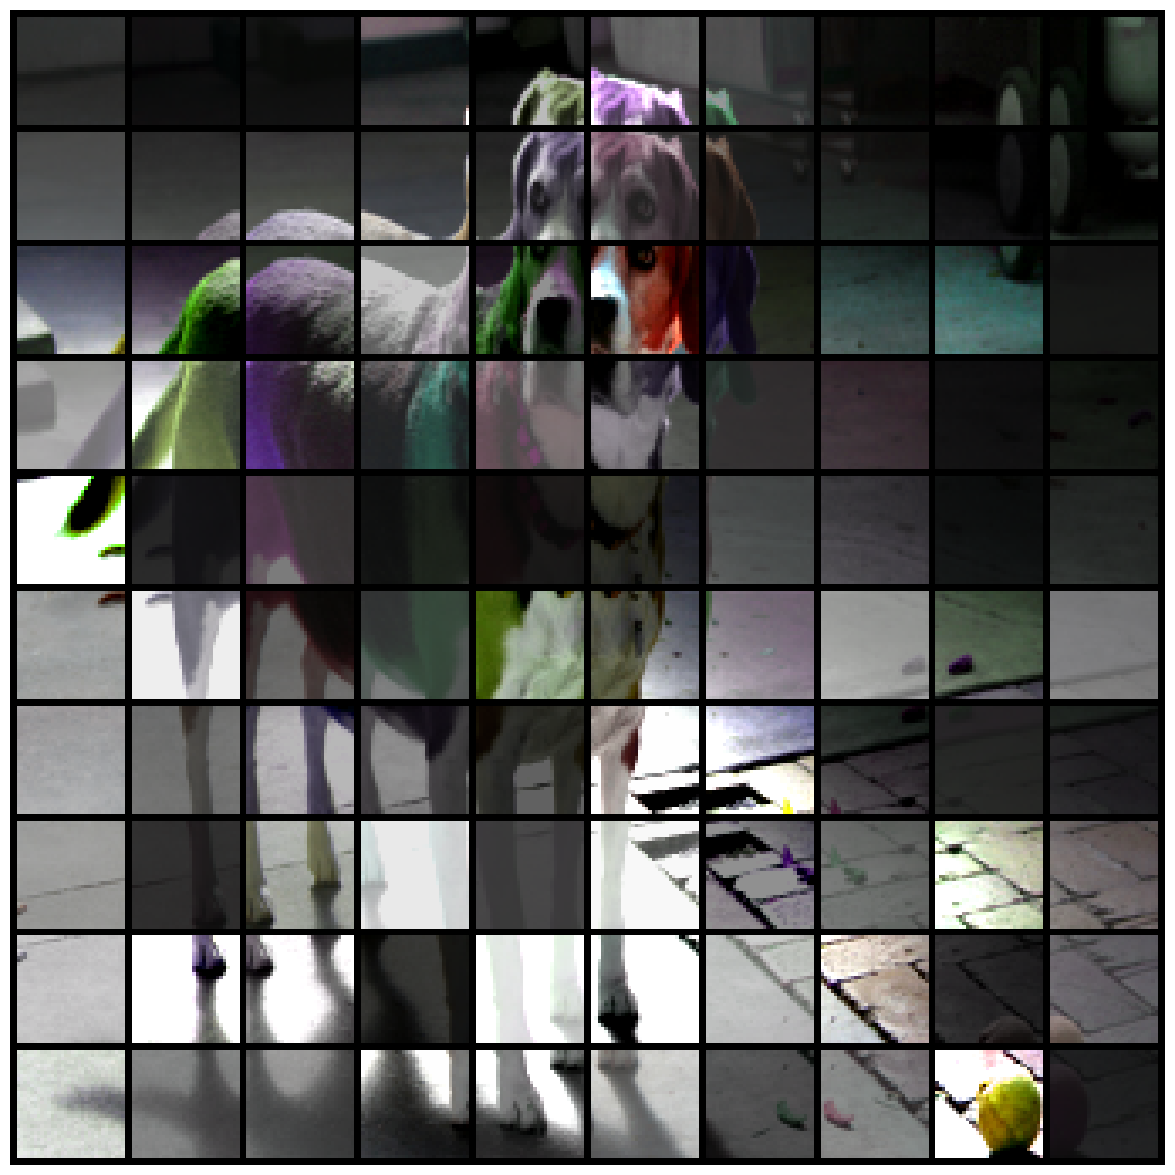

In [11]:
# Define a strong color jitter transformation
color_jitter = transforms.ColorJitter(
    brightness=0.8,  # Brightness variation
    contrast=0.8,    # Contrast variation
    saturation=0.8,  # Saturation variation
    hue=0.4          # Hue variation
)

# Augment patches and update the patch_tracking dictionary
for idx in patch_tracking:
    original_patch = patch_tracking[idx]["original"]
    augmented_patch = color_jitter(original_patch)  # Apply color jitter
    patch_tracking[idx]["augmented"] = augmented_patch  # Store augmented patch

# Extract augmented patches for display
augmented_patches = [patch_tracking[idx]["augmented"] for idx in patch_tracking]

# Display augmented patches using the provided function
display_patches(augmented_patches)

Preprocess patches for dictionary learning 

In [12]:
# Flatten patches and normalize
flattened_patches = [patch.numpy().flatten() for patch in augmented_patches]
scaler = StandardScaler()
normalized_patches = scaler.fit_transform(flattened_patches)

# Add the preprocessed patches to patch_tracking
for idx, normalized_patch in enumerate(normalized_patches):
    patch_tracking[idx]["preprocessed"] = normalized_patch


Do the dictionary learning 

In [61]:
# Step 1: Initialize dictionary learning model
dict_learner = DictionaryLearning(
    n_components=75,
    transform_algorithm='lasso_lars',
    transform_alpha=0.1,
    random_state=0,
    verbose=True,
    max_iter=1000 
)

In [62]:
# Step 2: Learn the dictionary
# Input: normalized_patches
dictionary = dict_learner.fit(normalized_patches)


[dict_learning] ...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [63]:
dictionary.n_iter_

463

In [64]:
dictionary_atoms = dictionary.components_

In [65]:
# Step 3: Get sparse codes for patches
sparse_codes = dict_learner.transform(normalized_patches)


In [66]:
# Step 4: Update patch_tracking dictionary
for idx, patch in enumerate(patch_tracking.values()):
    patch["dictionary_coefficients"] = sparse_codes[idx]



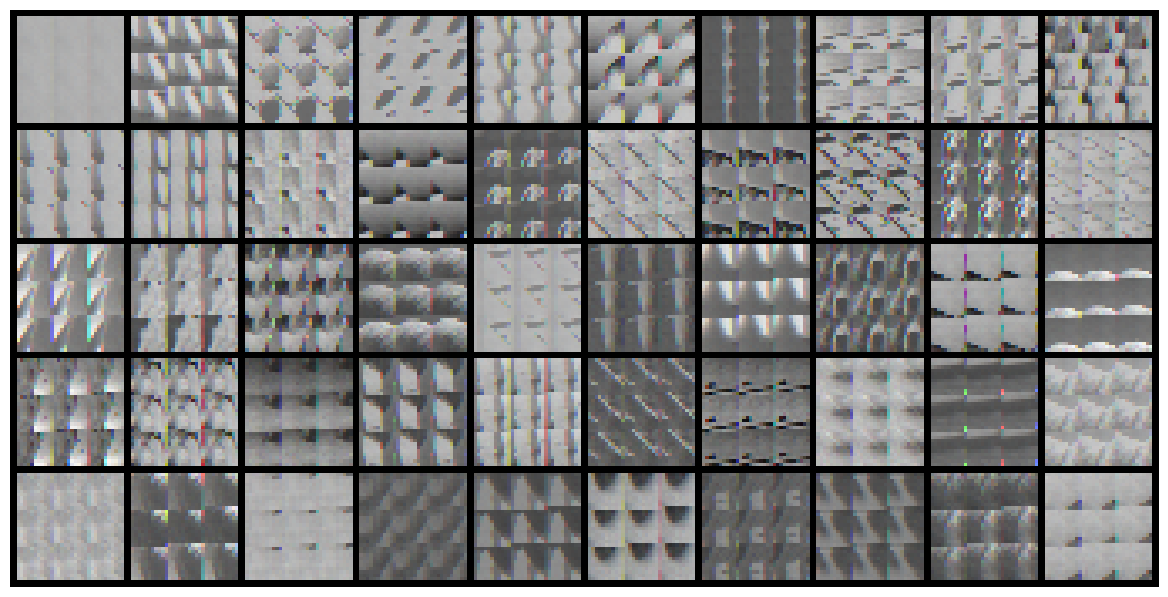

In [67]:
# Step 5: Visualize learned dictionary atoms
# Reshape the dictionary atoms to match the patch shape and visualize

# Convert reshaped_atoms (NumPy arrays) to PyTorch tensors
reshaped_atoms_tensors = [torch.tensor(atom).permute(2, 0, 1) for atom in reshaped_atoms]

# Display the reshaped dictionary atoms
display_patches(reshaped_atoms_tensors)

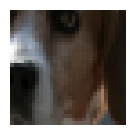

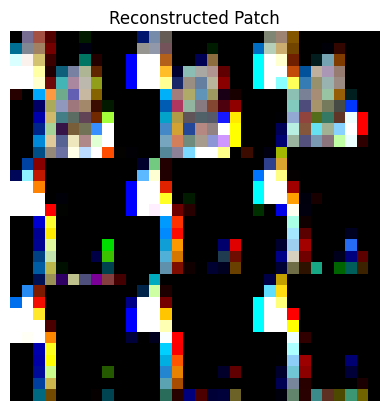

In [71]:
# Step 6: Analyze a reconstructed patch
sample_idx = 25  # Choose a patch to analyze

# Display the original patch
display_patches([patch_tracking[sample_idx]["original"]])

# Reconstruct the patch
reconstructed_patch = sparse_codes[sample_idx].dot(dictionary_atoms).reshape(patch_size, patch_size, 3)

# Normalize or clip values to ensure they are in the valid range
reconstructed_patch = np.clip(reconstructed_patch, 0, 1)

# Display the reconstructed patch
plt.imshow(reconstructed_patch)
plt.axis("off")
plt.title("Reconstructed Patch")
plt.show()
